To do:
- corriger les fotes d'ortograf
- vérifier les accents (qwerty seum)

<img src="https://julialang.org/assets/infra/logo.svg" width="200" />

# Julia par la pratique : le système de vie artificielle Lenia

«Toute technologie suffisamment avancée est indiscernable de la magie.»  
Arthur C. Clarke

## 1 Introduction

### 1.1 Notations utilisées dans ce notebook

| Symbole     | Signification |
|--------------|---------------|
| #️⃣1️⃣ `code` | explication de la première ligne de code de la cellule au-dessus (*) |
| ⚠️ | note plus ou moins importante |
| 🚨 | note importante |
| 🔥 | optimisation de code |  
(*) Pour afficher les numéros de lignes il faut appuyer sur [SHIFT] + l.

### 1.2 Le langage Julia 

Présentation des auteurs, traduit depuis le manuel :

Le calcul scientifique a toujours exigé des performances élevées, néanmoins les experts du domaine ont largement adopté des langages dynamiques plus lents pour leur travail quotidien.  

Nous pensons qu'il existe de très bonnes raisons de préférer les langages dynamiques pour ce domaine, et nous ne nous attendons pas à ce que leur utilisation diminue.  

Heureusement, les techniques modernes de conception de langages et de compilation permettent d'éliminer en grande partie le compromis entre la performance (déploiement d'applications à haute performance) et un langage dynamique (prototypage). 

Le langage de programmation Julia remplit ce rôle : il s'agit d'un langage dynamique flexible, adapté au calcul scientifique et numérique, avec des performances comparables à celles des langages traditionnels à typage statique.

Liens utiles pour apprendre et utiliser le langage de programmation Julia :
- [Manuel](https://docs.julialang.org/en/v1/)
- [Julia](https://julialang.org)
- [Télécharger Julia](https://julialang.org/downloads/)
- [Forum de discussion](https://discourse.julialang.org)
- [Chaîne YouTube](https://www.youtube.com/user/JuliaLanguage)
- [Liste de packages](https://juliapackages.com/)
- [Resources pédagogiques](https://julialang.org/learning/)

### 1.3 Objectifs de ce notebook

Le principal objectif de ce notebook est de présenter le langage en utilisant l'implémentation d'un cas concret ludique : [Lenia](https://en.wikipedia.org/wiki/Lenia). Cet exemple est suffisament simple pour ne nécessiter que peu de lignes de codes et à l'avantage de produire des sorties graphiques sympas à regarder.

Le deuxième objectif est de produire du code "propre" tel qu'il serait écrit dans un package. J'aurai pu faire un notebook plus typé "notebook", mais ça n'aurait pas permis d'aborder suffisament de notions de programmation (typage, structure, "multiple dispatch", etc...).

⚠️ Ce notebook n'est pas cours de programmation, il faut avoir quelques bases dans un autre langage pour le savourer.

⚠️ Ce notebook n'est pas cours complet de Julia, il y a des notions simples qui ne seront pas abordées et au contraire quelques notions avancées qui seront utilisées. Pour bien découvrir le langage le mieux est de lire le [manuel](https://docs.julialang.org/en/v1/).

🚨 On va utiliser le produit de convolution et la Transformation de Fourier Rapide, qui sont souvent des notions étrangères aux personnes n'ayant jamais fait de traitement du signal. Je ne pourrais pas inclure un cours complet sur ces deux notions dans ce notebook, donc si tu bloques là-dessus il faudra prendre le temps de lire des [ressources externes](https://fr.wikipedia.org/wiki/Wikip%C3%A9dia:Accueil_principal).

Comment lancer Jupyter depuis Julia (en même temps si t'es en train de lire ça tu sais probablement déjà faire) :
1. Ouvrir la REPL (taper julia dans une console Linux/Mac/X ou Windows Terminal)
2. taper `]`
3. entrer `add IJulia`
4. entrer `notebook`

## 2 Dépendances

L'écostystème Julia possède un très grand nombre de packages (ou bibliothèques en good french), il couvre très largement les cas d'usage en calcul scientifique, mais pas que, on peut même faire des applis web en Julia. Cela est dut au fait que Julia s'interface très facilement avec les bibliothèques écrites en C, C++ ou Fortran, de plus il existe les packages `PyCall` et `RCall` qui permettent de s'interfacer avec Python et R.

Pour installer des bibliothèques on peut le faire depuis le gestionnaire de paquets dans la REPL : 
- on appuie sur la touche `]`
- puis on entre la commande `add Plots`

Les dépendances sont incluses dans le projet avec le mot-clef `using` :
- `Plots` : bibliothèque pour faire des graphiques
- `FFTW` : bibliothèque pour calculer des transformées de Fourier
- `GLMakie` : bibliothèque pour faire des graphiques OpenGL

In [1]:
using Plots
using FFTW
import GLMakie: surface, volumeslices!

⚠️ Pour `GLMakie` on a remplacé `using` par `import`, car lorsque l'on fait `using Plots` on exporte dans l'espace global plusieurs fonctions pour créer des graphiques. Or la bibliothèque `GLMakie` exporte des fonctions avec les même noms (plot, heatmap, etc...).  
Avec `import GLMakie: surface, volume` on spécifie à Julia de n'importer que les fonctions `surface` et `volume`.

⚠️ Si tu veux installer des bibliothèques depuis le notebook (parceque la flemme d'ouvrir une REPL), tu peux utiliser `Pkg` :
```julia
import Pkg # On a pas besoin de polluer l'espace global
Pkg.add("Plots") 
```

## 3 Définition de quelques fonctions utilitaires

On va commencer par définir quelques fonctions utilitaires pour la suite du programme et qui vont permettre de faire une rapide présentation du langage Julia.

### 3.1 Fonction gaussienne

On va commencer par écrire une fonction gaussienne, qui sera bien pratique dans la suite du notebook :

In [2]:
"""
    gauss(x, μ, σ)

Computes the gaussian function with parameters μ and σ. The result
is not normalised, if you want the probability density function of 
a normally distributed random variable, you should divide the 
result by : \$\$ \\sigma \\sqrt{2 \\pi} \$\$.
"""
gauss(x, μ, σ) = exp(-0.5 * ((x - μ) / σ)^2)

gauss

#️⃣9️⃣ `gauss(x, μ, σ) = exp(-0.5 * ((x - μ) / σ)^2)`  
Il s'agit ici d'ici du mode d'écriture de fonction compacte sur une seule ligne, notre fonction `gauss` calcule la valeur pour `x` avec les paramètres `μ` et `σ`. Les caractères spéciaux tels que μ (resp. σ), sont obtenus en tapant `\mu` (resp. `\sigma`) suivit de la touche [TAB]. Il s'agit des mêmes codes que LaTex, du coup c'est très pratique.

#️⃣1️⃣ `""" ... """`  
La chaîne de caractères au-dessus de la fonction est une "doc-string", il s'agit de la documentation associée à la fonction `gauss`. On peut afficher la documentation avec `?` :

In [3]:
? gauss

search: gauss ignorestatus



```
gauss(x, μ, σ)
```

Computes the gaussian function with parameters μ and σ. The result is not normalised, if you want the probability density function of  a normally distributed random variable, you should divide the  result by : :$ \sigma \sqrt{2 \pi} :$.


On peut mettre des formules mathématiques dans les "doc-strings" (en syntaxe LaTex), malheureusement Jupyter n'est pas capable de les afficher, par contre ça marche très bien pour générer automatiquement la documentation d'un package en markdown.  
On teste notre nouvelle fonction `gauss` :

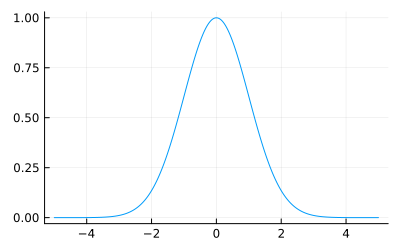

In [4]:
let x = -5:0.01:5
    plot(x, gauss.(x, 0, 1), size=(400,250), label = :none)
end

#️⃣1️⃣ `let ... end`  
La syntaxe `let ... end` permet de définir une portée (scope) locale, une fois sorti du bloque `let`, la variable `x` n'est pas dans la portée global :

In [5]:
x

LoadError: UndefVarError: `x` not defined

Le bloque `let ... end` n'est pas indispensable, la cellule du notebook se serait parfaitement exécutée sans. Cependant il évite d'avoir un notebook un peu cradingue avec tout un tas de variables temporaires inutiles dans l'espace global, du coup on évite les effets de bords entre les cellules du notebook. (J'avoue que c'est plus une préférence personnelle qu'une pratique courante)

Si à l'intérieur du bloque `let ... end` on a besoin de mettre le résultat d'un calcul dans l'espace global, on peut utiliser la syntaxe suivante :
```julia
let a = 42, b = 666
    global result
    result = foo(a, b)
end
```

#️⃣1️⃣ `x = -5:0.01:5`  
Il s'agit de la syntaxe Julia pour définir une plage de valeurs allant de -5 à 5 avec un pas de 0.01. Si on veut l'ensemble de ces valeurs dans un vecteur, on utilise la fonction `collect` :
```julia
collect(-5:0.01:5) 
```
`-5:0.01:5` est itérable :
```julia
for x in -5:0.01:5
    println(x)
end
```
Ou bien avec `∈` :
```julia
for x ∈ -5:0.01:5
    println(x)
end
```

⚠️ L'opérateur `∈` peut aussi tester si une valeur est dans un ensemble donné:
```julia
1 ∈ [1, 2, 3]  # renvoie vrai
1 !∈ [1, 2, 3] # renvoie faux
```
`[1, 2, 3]` => définit un vecteur

#️⃣2️⃣ `gauss.(x, 0, 1)`
On remarque que l'on appelle ici `gauss.` au lieu de `gauss`, cela permet de vectoriser la fonction sur tout les éléments de `x` qui est une plage de valeurs. On peut aussi appeler `gauss` avec la macro `@.` :
```julia
plot(x, @. gauss(x, 0, 1))
```
⚠️ Une macro est une "fonction" qui va générer du code à partir de ses arguments, il s'agit de métaprogrammation. C'est une notion de programmation très avancée que je ne développerais pas ici, connaître leur usage est amplement suffisant.

### 3.2 Fonction Δrng
Cette fonction est une fonction utilitaire pour la fonction utilitaire suivante `distmap`. Cette fonction va permettre de créer, étant donné un entier `n`, une plage de valeur entière de longueur `n` et centrée autour de 0.  
Par exemple si n = 3, on veut la plage de valeur [-1, 0, 1].

In [6]:
function Δrng(n)
    h1 = n ÷ 2
    h2 = iseven(n) ? h1 - 1 : h1
    -h1:h2
end

Δrng (generic function with 1 method)

#️⃣1️⃣ `function Δrng(n)`  
Il s'agit tout simplement de la déclaration de la fonction `Δrng` avec pour argument `n`. Le `end` marque la fin de la portée de la fonction.

#️⃣2️⃣ `h1 = n ÷ 2`  
On divise `n` par 2, mais au lieu de l'opérateur classique `/` qui nous renverrait un nombre a virgule flottante, on utilise l'opérateur `÷` qui est une une division entière (\div + [TAB]), donc `h1` est bien un nombre entier.

#️⃣3️⃣ `h2 = iseven(n) ? h1 - 1 : h1`  
Il s'agit d'un test conditionnel ternaire de la forme `a = condition ? valeur_si_vraie : valeur_si_fausse`, si la `condition` est vérifiée alors `a` prends la valeur `valeur_si_vraie` sinon la valeur `valeur_si_fausse`. On peut aussi l'écrire :
```julia
if iseven(n)
    h2 = h1 - 1
else
    h2 = h1
end
```

#️⃣4️⃣ `-h1:h2`  
Finalement, on renvoie la plage de valeur `-h1:h2`, il faut noter que c'est la dernière expression évaluée qui est renvoyé par la fonction, c'est l'héritage fonctionnel de Julia. Si tu préfères tu peux mettre le mot clef `return` :
```julia
function Δrng(n)
    h1 = n ÷ 2
    h2 = iseven(n) ? h1 - 1 : h1
    return -h1:h2
end
```

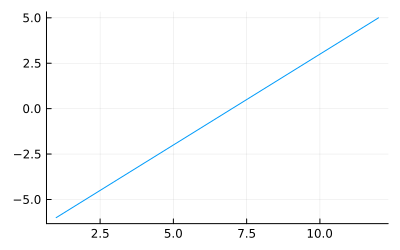

In [7]:
plot(Δrng(12), size=(400,250), label = :none)

### 3.3 Fonction distmap

Cette fonction va permettre de créer une carte de distances euclidiennes avec pour origine le centre de la carte. Cette carte prendra pour argument un tuple `(hauteur,largeur)` qui définira sa dimension :

In [8]:
function distmap(sz::NTuple{2,Int})
    height, width = sz
    [sqrt(x^2 + y^2) for y ∈ Δrng(height), x ∈ Δrng(width)]
end

distmap (generic function with 1 method)

#️⃣1️⃣ `function distmap(sz::NTuple{2})`  
On voit ici que dans la déclaration de la fonction on a déclarer le type de l'argument `sz::NTuple{2,Int}`, c'est à dire que `sz` est un tuple de longueur 2. On verra juste après pourquoi on fait ça. Un tuple a pour type `NTuple{N,T}` ou `N` est un entier définissant la longueur, et `T` définissant le type des éléments stockés dans le tuple. Il s'agit d'un type paramétré, si tu veux en savoir plus tu peux lire [la section correspondante dans le manuel](https://docs.julialang.org/en/v1/manual/types/#Parametric-Types).

#️⃣2️⃣ `height, width = sz`  
Il s'agit ici d'une assignation par déstructuration : les valeurs dans le tuple sont assignées à `height` et `width`.

#️⃣3️⃣ `[sqrt(x^2 + y^2) for y ∈ Δrng(height), x ∈ Δrng(width)]`  
Il s'agit ici d'une liste en compréhension, c'est une manière compacte de créer des tableaux. Une forme alternative et plus verbeuse serait :
```julia
D = zeros(height, width)
for y ∈ Δrng(height)
    for x ∈ Δrng(width)
        D[y,x] = sqrt(x^2 + y^2)
    end
end
```

On teste notre fonction `distmap` :

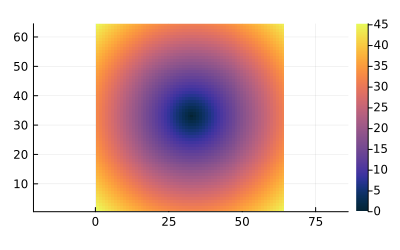

In [9]:
heatmap(distmap((64,64)), ratio = 1, c = :thermal, size=(400,250))

Pour une visualisation 3D :

In [10]:
surface(distmap((64, 64)), colormap = :thermal) |> display

GLMakie.Screen(...)

Pour le moment la fonction `distmap` est définie pour deux dimensions, si on veut l'étendre à trois dimensions, on pourrait ne pas typer l'argument `sz` et mettre un branchement `if-elseif` sur la longueur de `sz`:
```julia
function distmap(sz)
    if length(sz) == 2
        height, width = sz
        [sqrt(x^2 + y^2) for y ∈ Δrng(height), x ∈ Δrng(width)]
    elseif length(sz) == 3
        height, width, depth = sz
        [sqrt(x^2 + y^2 + z^2) for y ∈ Δrng(height), x ∈ Δrng(width), z ∈ Δrng(depth)]
    else
        error("Shit happen!")
    end
end
```
En Julia il y a une alternative très puissante et très performante qui consiste à écrire une deuxième version de `distmap`, mais cette fois en forçant le type de `sz` a un tuple de longueur 3 :

In [11]:
function distmap(sz::NTuple{3,Int})
    height, width, depth = sz
    [sqrt(x^2 + y^2 + z^2) for y ∈ Δrng(height), x ∈ Δrng(width), z ∈ Δrng(depth)]
end

distmap (generic function with 2 methods)

On voit maintenant que `distmap` est une fonction avec deux méthodes (c-à-d deux implémentations). C'est ce que l'on appelle le ***multiple dispatch***, le compilateur de Julia va directement appeler la méthode correspondant au bon type que l'on passe en argument.

L'avantage c'est que si on passe un argument invalide, on a directement un message d'erreur clair :

In [12]:
distmap("pouet pouet")

LoadError: MethodError: no method matching distmap(::String)

[0mClosest candidates are:
[0m  distmap([91m::Tuple{Int64, Int64, Int64}[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[11]:1[24m[39m
[0m  distmap([91m::Tuple{Int64, Int64}[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[8]:1[24m[39m


Pour finir avec la fonction `distmap`, si on veut l'appeller de cette façon `distmap(64, 64)`, au lieu de `distmap((64,64))`, on peut utiliser une [fonction variadique](https://fr.wikipedia.org/wiki/Fonction_variadique), c'est à dire une fonction avec un nombre indéfini d'arguments, signalisée par `...` :

In [13]:
distmap(d...) = distmap(d)

distmap (generic function with 3 methods)

On teste la version tridimensionnelle, la cellule ci-dessous présente une démo de GLMakie, je ne commente pas ligne à ligne (je ferai un autre notebook spécifique pour GLMakie) :

In [14]:
let
    import GLMakie: Figure, LScene, SliderGrid, on

    x, y, z = 1:64, 1:64, 1:64
    vol = distmap(64, 64, 64)
    
    fig = Figure()
    ax = LScene(fig[1, 1], show_axis = false)
    
    plt = volumeslices!(ax, x, y, z, vol, colormap = :thermal)

    sgrid = SliderGrid(
        fig[2, 1],
        (label = "yz plane - x axis", range = x),
        (label = "xz plane - y axis", range = y),
        (label = "xy plane - z axis", range = z),
    )

    # connect sliders to `volumeslices` update methods
    sl_yz, sl_xz, sl_xy = sgrid.sliders
    on(v -> plt[:update_yz][](v), sl_yz.value)
    on(v -> plt[:update_xz][](v), sl_xz.value)
    on(v -> plt[:update_xy][](v), sl_xy.value)
    
    display(fig)
end
#volume(distmap(64, 64, 64), algorithm = :iso, isovalue = 30, isorange = 0.5, interpolate = true, colormap = :thermal) |> display

GLMakie.Screen(...)

### 3.4 Fonction clip

Cette fonction va permettre de contraindre une valeur réelle x dans l'intervalle [0, 1] : si x est inférieure à 0 alors `clip` renvoie 0 et si x est supérieure à 1 alors `clip` renvoie 1. On va définir une première méthode qui coupe brutalement en utilisant la fonction de base `clamp` :  

In [15]:
clip(::Val{:hard}, x) = clamp(x, 0, 1)

clip (generic function with 1 method)

#️⃣1️⃣ `Val{:hard}`  
Définit un type qui contient le symbol `:hard`, quand on appellera la fonction `clip` en mode hard il suffit de passer `Val(:hard)` en argument.

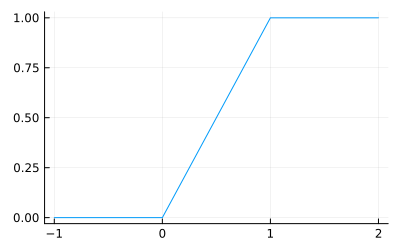

In [16]:
plot(-1:0.01:2, clip.(Val(:hard), -1:0.01:2), size=(400,250), label = :none)

On va définir une deuxième méthode à l'aide d'une fonction sigmoïde, qui fera une coupure plus douce :

In [17]:
clip(::Val{:soft}, x) = 1 / (1 + exp(-4 * x + 2))

clip (generic function with 2 methods)

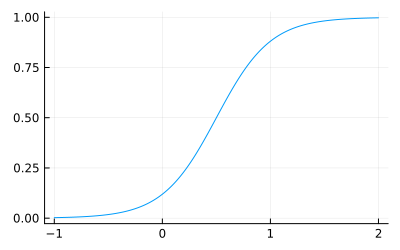

In [18]:
plot(-1:0.01:2, clip.(Val(:soft), -1:0.01:2), size=(400,250), label = :none)

Enfin on va définir une troisième méthode qui va nous permettre d'alléger les appels de `clip` en passant directement le symbol en argument :

In [19]:
clip(s::Symbol, x) = clip(Val(s), x)

clip (generic function with 3 methods)

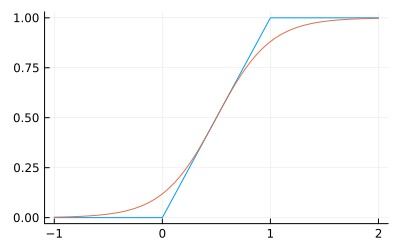

In [20]:
plot(-1:0.01:2, clip.(:hard, -1:0.01:2), size=(400,250), label = :none)
plot!(-1:0.01:2, clip.(:soft, -1:0.01:2), label = :none)

⚠️ quand on appelle la fonction `plot!` le `!` signifie que cette fonction a un effet de bord, en effet on a modifié le premier graphique en ajoutant une nouvelle courbe.

In [21]:
function visualize(M; colormap = :thermal, scale = 1) 
    heatmap(
        M,
        aspect_ratio = :equal,
        clims = (0, 1),
        c = colormap,
        cbar = false,
        framestyle = :none,
        margins = -100Plots.px,
        size = scale .* reverse(size(M)),
        yflip = true
    )
end

function animmp4(Ss; path = "", name, colormap = :thermal, scale = 2, fps = 30)
    anim = @animate for S ∈ Ss
        visualize(S, colormap = colormap, scale = scale)
    end
    pth = isempty(path) ? joinpath(mktempdir(), "$name.mp4") : joinpath(path, "$name.mp4")
    mp4(anim, pth, fps = fps)
end

animmp4 (generic function with 1 method)

In [22]:
#ispow2(x) = x > 0 && (x & (x - 1)) == 0

## 4 Lenia V1

### 4.1 Présentation
Lenia (from Latin lenis, “smooth”) is a cellular automaton, like Conway’s Game of Life, but with continuous states and continuous space-time. It supports a great diversity of complex autonomous patterns or "lifeforms" bearing resemblance to real-world microscopic organisms. More than 400 species in 18 families have been identified, many discovered via interactive evolutionary computation.


In [23]:
struct Lenia
    kernel
    growth
    shape
    dt
    clip
end

Lenia(kernel, growth, shape, dt = 0.1; clip = :hard) = Lenia(kernel, growth, shape, dt, clip)

kernel(lenia) = lenia.kernel(lenia.shape)

kernel (generic function with 1 method)

### 4.2 Fonction de voisinnage

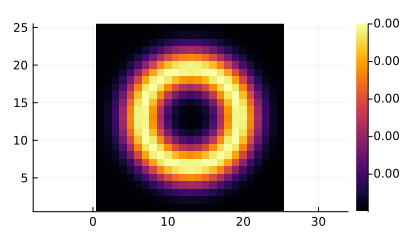

In [24]:
struct GaussRK
    p
    μ
    σ
end

GaussRK(μ, σ) = GaussRK([1], [μ], [σ])

function (k::GaussRK)(shape)
    d = distmap(shape)
    K = zeros(shape...)
    for (p, μ, σ) ∈ zip(k.p, k.μ, k.σ)
        K = @. K + p * gauss(d, μ, σ)
    end
    K ./ sum(K)
end

(k::GaussRK)(d...) = k(d)

let μ = 6.5, σ = 1.95
    k = GaussRK(μ, σ)
    K = k(25, 25)
    heatmap(K, aspect_ratio = :equal, size = (400,250))
end

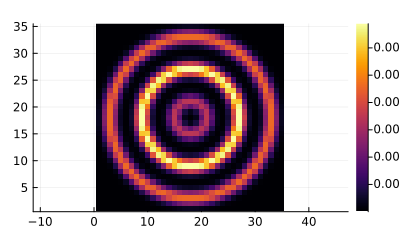

In [25]:
let p = [1//2 1 2//3], μ = [3 9 15], σ = [0.9 0.9 0.9] 
    k = GaussRK(p, μ, σ)
    K = k(35, 35)
    heatmap(K, aspect_ratio = :equal, size = (400,250))
end

### 4.3 Fonction de croissance

In [26]:
struct GaussGr
    μ
    σ
end

(g::GaussGr)(x) = 2 * gauss(x, g.μ, g.σ) - 1

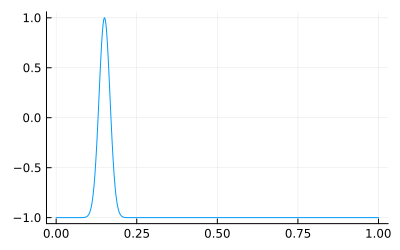

In [27]:
let a = 0:0.001:1, μ = 0.15, σ = 0.017
    growth = GaussGr(μ, σ)
    plot(a, growth.(a), size=(400,250), label = :none)
end

### 4.4 Application de la fonction de voisinnage 
#### 4.4.1 Principe du produit de convolution
##### a. Formulation continue


##### b. Application discrète 
<img src="https://media.tenor.com/NNR7BkQ8Q7QAAAAi/convolution-math.gif" width="600" />
<!-- <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/0*e-SMFTzO8r7skkpc" width="600" /> -->

#### 4.4.2 Convolution dans le domaine de Fourier
Bords périodiques
ecrire une premiere fonction convolve naive

#### 4.3.2 🔥 Convolution

convolve(X, Kf, Pf, Pi) = real.(ifftshift(Pi * ((Pf * X) .* Kf)))

Faire un benchmark

In [28]:
struct ConvPlan
    # Forward FFT plan
    Pf
    # Inverse FFT plan
    Pi
    # Kernel in Fourier domain
    K̂
end

function ConvPlan(K)
    Pf = plan_rfft(K)
    K̂ = Pf * K
    Pi = plan_irfft(K̂, first(size(K)))
    ConvPlan(Pf, Pi, K̂)
end

ConvPlan(l::Lenia) = ConvPlan(kernel(l))

#=    K = kernel(shape)
    Pf = plan_rfft(K)
    K̂ = Pf * K
    Pi = plan_irfft(K̂, first(shape))
    ConvPlan(Pf, Pi, K̂)
end=#

#ConvPlan(lenia) = ConvPlan(lenia.kernel, lenia.shape)

convolve(A, p::ConvPlan) = ifftshift(p.Pi * (p.Pf * A .* p.K̂))

convolve (generic function with 1 method)

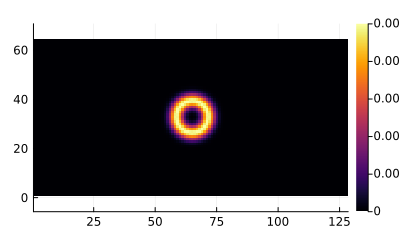

true

In [29]:
let shape = (64, 128), μ = 6.5, σ = 1.95
    k = GaussRK(μ, σ)
    p = ConvPlan(k(shape))
    A = zeros(shape...)
    A[end ÷ 2 + 1, end ÷ 2 + 1] = 1
    heatmap(convolve(A, p), aspect_ratio = :equal, size=(400,250)) |> display
    (sum(convolve(A, p)) ≈ 1) |> display
end

### 4.5 Évolution du système

In [30]:
Base.size(l::Lenia) = l.shape

primsoup(::Type{T}, lenia) where T <: AbstractFloat = rand(T, size(lenia)...)

primsoup(lenia) = primsoup(Float64, lenia)

function lifeform(lenia, L)
    sl, sL = size(lenia), size(L)
    st = @. sl ÷ 2 - sL ÷ 2
    ed = @. st + sL - 1
    X = zeros(sl...)
    X[[UnitRange(s, e) for (s, e) ∈ zip(st, ed)]...] .= L
    X
end

function evolve(lenia, S, p)
    U = convolve(S, p)
    clip.(lenia.clip, S + lenia.dt * lenia.growth.(U))
end

function evolve(lenia, S, p, nite)
    Ss = [deepcopy(S)]
    i = 1
    for i in 1:nite
        S = evolve(lenia, S, p) #lenia(S, p)
        push!(Ss, S)
    end
    Ss
end

evolve (generic function with 2 methods)

### 4.6 Simulations
La plupart du temps l'évolution à partir d'une soupe primordiale conduit à des formes inorganiques :

In [31]:
let shape = (64, 128), kernel = GaussRK(6.5, 1.95), growth = GaussGr(0.15, 0.017), nite = 100
    lenia = Lenia(kernel, growth, shape)
    W = primsoup(lenia)
    cp = ConvPlan(lenia)
    Wt = evolve(lenia, W, cp, nite)
    animmp4(Wt, name = "lenia_test", scale = 4)
end

[ Info: Saved animation to /tmp/jl_Nv30TN/lenia_test.mp4


Plots.AnimatedGif("/tmp/jl_Nv30TN/lenia_test.mp4")

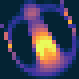

In [32]:
if !@isdefined Orbium_unicaudatus
    const Orbium_unicaudatus = [0 0 0 0 0 0 0.1 0.14 0.1 0 0 0.03 0.03 0 0 0.3 0 0 0 0;0 0 0 0 0 0.08 0.24 0.3 0.3 0.18 0.14 0.15 0.16 0.15 0.09 0.2 0 0 0 0; 0 0 0 0 0 0.15 0.34 0.44 0.46 0.38 0.18 0.14 0.11 0.13 0.19 0.18 0.45 0 0 0; 0 0 0 0 0.06 0.13 0.39 0.5 0.5 0.37 0.06 0 0 0 0.02 0.16 0.68 0 0 0; 0 0 0 0.11 0.17 0.17 0.33 0.4 0.38 0.28 0.14 0 0 0 0 0 0.18 0.42 0 0; 0 0 0.09 0.18 0.13 0.06 0.08 0.26 0.32 0.32 0.27 0 0 0 0 0 0 0.82 0 0; 0.27 0 0.16 0.12 0 0 0 0.25 0.38 0.44 0.45 0.34 0 0 0 0 0 0.22 0.17 0; 0 0.07 0.2 0.02 0 0 0 0.31 0.48 0.57 0.6 0.57 0 0 0 0 0 0 0.49 0; 0 0.59 0.19 0 0 0 0 0.2 0.57 0.69 0.76 0.76 0.49 0 0 0 0 0 0.36 0; 0 0.58 0.19 0 0 0 0 0 0.67 0.83 0.9 0.92 0.87 0.12 0 0 0 0 0.22 0.07; 0 0 0.46 0 0 0 0 0 0.7 0.93 1 1 1 0.61 0 0 0 0 0.18 0.11; 0 0 0.82 0 0 0 0 0 0.47 1 1 0.98 1 0.96 0.27 0 0 0 0.19 0.1; 0 0 0.46 0 0 0 0 0 0.25 1 1 0.84 0.92 0.97 0.54 0.14 0.04 0.1 0.21 0.05; 0 0 0 0.4 0 0 0 0 0.09 0.8 1 0.82 0.8 0.85 0.63 0.31 0.18 0.19 0.2 0.01; 0 0 0 0.36 0.1 0 0 0 0.05 0.54 0.86 0.79 0.74 0.72 0.6 0.39 0.28 0.24 0.13 0; 0 0 0 0.01 0.3 0.07 0 0 0.08 0.36 0.64 0.7 0.64 0.6 0.51 0.39 0.29 0.19 0.04 0; 0 0 0 0 0.1 0.24 0.14 0.1 0.15 0.29 0.45 0.53 0.52 0.46 0.4 0.31 0.21 0.08 0 0; 0 0 0 0 0 0.08 0.21 0.21 0.22 0.29 0.36 0.39 0.37 0.33 0.26 0.18 0.09 0 0 0; 0 0 0 0 0 0 0.03 0.13 0.19 0.22 0.24 0.24 0.23 0.18 0.13 0.05 0 0 0 0; 0 0 0 0 0 0 0 0 0.02 0.06 0.08 0.09 0.07 0.05 0.01 0 0 0 0 0];
end
if !@isdefined orbpar
    const orbpar = Dict(:kernel => GaussRK(6.5, 1.95), :growth => GaussGr(0.15, 0.017))
end
visualize(Orbium_unicaudatus, scale = 4)

In [33]:
let shape = (64, 128), nite = 100
    lenia = Lenia(orbpar[:kernel], orbpar[:growth], shape)
    W = lifeform(lenia, Orbium_unicaudatus)
    cp = ConvPlan(lenia) #orbpar[:kernel], shape
    Wt = evolve(lenia, W, cp, nite)
    animmp4(Wt, name = "lenia_test", scale = 4)
end

[ Info: Saved animation to /tmp/jl_Ljkqfm/lenia_test.mp4


Plots.AnimatedGif("/tmp/jl_Ljkqfm/lenia_test.mp4")

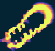

In [34]:
if !@isdefined Hydrogeminium_natans
    const Hydrogeminium_natans = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.02 0.03 0.04 0.04 0.04 0.03 0.02 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.04 0.1 0.16 0.2 0.23 0.25 0.24 0.21 0.18 0.14 0.1 0.07 0.03 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.09 0.2 0.33 0.44 0.52 0.56 0.58 0.55 0.51 0.44 0.37 0.3 0.23 0.16 0.08 0.01 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.13 0.29 0.45 0.6 0.75 0.85 0.9 0.91 0.88 0.82 0.74 0.64 0.55 0.46 0.36 0.25 0.12 0.03 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.14 0.38 0.6 0.78 0.93 1.0 1.0 1.0 1.0 1.0 1.0 0.99 0.89 0.78 0.67 0.56 0.44 0.3 0.15 0.04 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.08 0.39 0.74 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.98 0.85 0.74 0.62 0.47 0.3 0.14 0.03 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.32 0.76 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.88 0.75 0.61 0.45 0.27 0.11 0.01 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.35 0.83 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.88 0.73 0.57 0.38 0.19 0.05 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.5 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.99 1.0 1.0 1.0 1.0 0.99 1.0 1.0 1.0 1.0 1.0 1.0 0.85 0.67 0.47 0.27 0.11 0.01; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.55 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.93 0.83 0.79 0.84 0.88 0.89 0.9 0.93 0.98 1.0 1.0 1.0 1.0 0.98 0.79 0.57 0.34 0.15 0.03; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.47 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.9 0.72 0.54 0.44 0.48 0.6 0.7 0.76 0.82 0.91 0.99 1.0 1.0 1.0 1.0 0.91 0.67 0.41 0.19 0.05; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.27 0.99 1.0 1.0 1.0 1.0 0.9 0.71 0.65 0.55 0.38 0.2 0.14 0.21 0.36 0.52 0.64 0.73 0.84 0.95 1.0 1.0 1.0 1.0 1.0 0.78 0.49 0.24 0.07; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.14 0.63 0.96 1.0 1.0 1.0 0.84 0.17 0 0 0 0 0 0 0 0.13 0.35 0.51 0.64 0.77 0.91 0.99 1.0 1.0 1.0 1.0 0.88 0.58 0.29 0.09; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.07 0.38 0.72 0.95 1.0 1.0 1.0 0.22 0 0 0 0 0 0 0 0 0 0.11 0.33 0.5 0.67 0.86 0.99 1.0 1.0 1.0 1.0 0.95 0.64 0.33 0.1; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.32 0.49 0.71 0.93 1.0 1.0 1.0 0.56 0 0 0 0 0 0 0 0 0 0 0 0.1 0.31 0.52 0.79 0.98 1.0 1.0 1.0 1.0 0.98 0.67 0.35 0.11; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.6 0.83 0.98 1.0 1.0 0.68 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.15 0.38 0.71 0.97 1.0 1.0 1.0 1.0 0.97 0.67 0.35 0.11; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.51 0.96 1.0 1.0 0.18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.09 0.34 0.68 0.95 1.0 1.0 1.0 1.0 0.91 0.61 0.32 0.1; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.13 0.56 0.99 1.0 1.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.17 0.45 0.76 0.96 1.0 1.0 1.0 1.0 0.82 0.52 0.26 0.07; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.33 0.7 0.94 1.0 1.0 0.44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.33 0.68 0.91 0.99 1.0 1.0 1.0 1.0 0.71 0.42 0.19 0.03; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.53 0.89 1.0 1.0 1.0 0.8 0.43 0.04 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.47 0.86 1.0 1.0 1.0 1.0 1.0 0.95 0.58 0.32 0.12 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.77 0.99 1.0 0.97 0.58 0.41 0.33 0.18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.54 0.95 1.0 1.0 1.0 1.0 1.0 0.8 0.44 0.21 0.06 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.39 0.83 1.0 1.0 0.55 0.11 0.05 0.15 0.22 0.06 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.58 0.99 1.0 1.0 1.0 1.0 1.0 0.59 0.29 0.11 0.01 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.04 0.55 0.81 0.86 0.97 1.0 1.0 0.5 0 0 0.01 0.09 0.03 0 0 0 0 0 0 0 0 0 0 0 0 0 0.26 0.78 1.0 1.0 1.0 1.0 1.0 0.66 0.35 0.13 0.03 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.33 1.0 1.0 1.0 1.0 1.0 1.0 0.93 0.11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.23 0.73 0.95 1.0 1.0 1.0 1.0 1.0 0.62 0.35 0.12 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.51 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.72 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.56 0.25 0.09 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.12 0.38 1.0 1.0 1.0 0.66 0.08 0.55 1.0 1.0 1.0 0.03 0 0 0 0 0 0 0 0 0 0 0 0 0 0.35 1.0 1.0 1.0 1.0 1.0 1.0 0.67 0.12 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0.6 1.0 1.0 1.0 1.0 1.0 1.0 0.49 0 0 0.87 1.0 0.88 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.0 1.0 1.0 1.0 1.0 1.0 0.7 0.07 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0.04 0.21 0.48 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0 0 0.04 0.42 0.26 0 0 0 0 0 0 0 0 0 0.12 0.21 0.34 0.58 1.0 1.0 1.0 0.99 0.97 0.99 0.46 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0.5 1.0 1.0 1.0 1.0 0.96 0 0.31 1.0 1.0 1.0 0.53 0 0 0 0 0 0 0 0 0.2 0.21 0 0 0 0.27 1.0 1.0 1.0 1.0 1.0 1.0 0.87 0.52 0.01 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0.84 1.0 1.0 1.0 1.0 1.0 0 0 0 0.83 1.0 1.0 0.52 0 0 0 0 0 0 0 0.26 0.82 0.59 0.02 0 0 0.46 1.0 1.0 1.0 1.0 1.0 0.9 0.55 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0.39 0.99 1.0 1.0 1.0 1.0 0.78 0.04 0 0 0 0.93 0.92 0 0 0 0 0 0 0 0 0.69 1.0 1.0 0.36 0 0 1.0 1.0 0.65 0.66 0.97 0.87 0.54 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0.55 0.75 0.59 0.74 1.0 1.0 0 0 0.75 0.71 0.18 0 0 0 0 0 0 0 0 0 0 0.29 0 0 0.45 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.47 0.39 0.71 0.25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0.69 0.81 0.8 0.92 1.0 0.13 0 0 0.13 0.94 0.58 0 0 0 0 0 0 0 0 0 1.0 1.0 0.34 0 0.04 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0.63 0.85 0.9 0.98 1.0 0.09 0 0 0.02 1.0 0.64 0 0 0 0 0 0 0 0 0.59 1.0 1.0 0.84 0 0 1.0 1.0 1.0 1.0 1.0 1.0 0.64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0.64 0.65 0.67 1.0 1.0 0.21 0.01 0 0.04 0.02 0 0 0 0 0 0 0 0 0 0.69 1.0 1.0 1.0 0.29 0.37 1.0 1.0 0.6 0.63 1.0 0.84 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0.44 0.73 0.73 0.85 1.0 0.97 0.23 0.05 0 0 0 0 0 0 0 0 0.06 0 0 0 0.97 1.0 1.0 1.0 1.0 1.0 1.0 0.33 0.24 0.67 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0.12 0.55 0.9 0.9 1.0 1.0 1.0 0.43 0.04 0 0 0 0 0 0 0 0.31 0.54 0 0 0 0.88 1.0 1.0 1.0 1.0 1.0 1.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0.29 0.71 1.0 1.0 1.0 1.0 0.79 0.28 0 0 0 0 0 0 0 0 0.4 0.77 0.54 0 0 0.87 1.0 1.0 1.0 1.0 1.0 0.31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0.16 0.27 0.41 0.72 0.99 1.0 1.0 0.82 0.42 0.09 0 0 0 0 0 0 0 0 0.1 0.55 0.58 0.58 0.77 0.99 1.0 1.0 1.0 1.0 0.63 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0.31 0.48 0.45 0.46 0.63 0.88 1.0 0.83 0.59 0.28 0.06 0 0 0 0 0 0 0 0 0 0.32 0.7 0.95 1.0 1.0 1.0 1.0 0.7 0.58 0.12 0.04 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0.23 0.54 0.53 0.48 0.57 0.59 0.65 0.63 0.55 0.35 0.13 0.03 0.02 0.09 0.74 1.0 0.09 0 0 0 0.32 0.86 1.0 1.0 1.0 1.0 0.57 0.44 0.31 0.16 0.01 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0.31 0.45 0.31 0.18 0.28 0.39 0.47 0.54 0.5 0.35 0.2 0.16 0.28 0.75 1.0 0.42 0.01 0 0 0.6 1.0 1.0 1.0 1.0 0.51 0.29 0.09 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0.14 0.3 0.4 0.54 0.71 0.74 0.65 0.49 0.35 0.27 0.47 0.6 0.6 0.72 0.98 1.0 1.0 1.0 1.0 0.65 0.33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0.06 0.33 0.53 0.69 0.94 0.99 1.0 0.84 0.41 0.16 0.15 0.96 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.73 0.13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0.42 0.86 0.98 0.98 0.99 1.0 0.94 0.63 0.32 0.62 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.65 0.23 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0.07 0.62 0.95 1.0 1.0 0.99 0.98 0.99 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.98 0.14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0.03 0.46 0.89 1.0 1.0 0.97 0.83 0.75 0.81 0.94 1.0 1.0 1.0 1.0 0.99 0.03 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0.14 0.57 0.88 0.93 0.81 0.58 0.45 0.48 0.64 0.86 0.97 0.99 0.99 0.42 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0.23 0.45 0.47 0.39 0.29 0.19 0.2 0.46 0.28 0.03 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0.08 0.22 0.24 0.15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0.07 0.22 0.14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0];
end
if !@isdefined hydroparam
    const hydropar = Dict(
        :kernel => GaussRK([1//2, 1, 2//3], [3, 9, 15], [0.9, 0.9, 0.9]),
        :growth => GaussGr(0.26, 0.036)
    )
end

visualize(Hydrogeminium_natans)

In [35]:
let shape = (128, 256), nite = 100
    lenia = Lenia(hydropar[:kernel], hydropar[:growth], shape)
    W = lifeform(lenia, Hydrogeminium_natans)
    cp = ConvPlan(lenia)
    Wt = evolve(lenia, W, cp, nite)
    animmp4(Wt, name = "lenia_test", scale = 2)
end

[ Info: Saved animation to /tmp/jl_rgDs8w/lenia_test.mp4


Plots.AnimatedGif("/tmp/jl_rgDs8w/lenia_test.mp4")

In [36]:
if !@isdefined Asterium_tardus
    const Asterium_tardus = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.03 0.04 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.49 0.77 1.00 1.00 0.90 0.35 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0.09 0.95 1.00 1.00 1.00 1.00 1.00 0.94 0 0 0 0 0 0 0; 0 0 0 0 0.28 0.51 0.30 0 0 0 0 0 0 0.29 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.52 0 0 0 0 0 0; 0 0 0 0.76 1.00 1.00 0.91 0.55 0.38 0 0 0.04 0.60 0.87 1.00 1.00 1.00 0.99 1.00 1.00 1.00 0.53 0 0 0 0 0 0; 0 0 0.60 1.00 1.00 1.00 1.00 1.00 1.00 0.70 0.73 0.82 1.00 1.00 1.00 1.00 0.87 0.78 0.97 1.00 1.00 0.40 0 0 0 0 0 0; 0 0.11 1.00 1.00 1.00 1.00 1.00 1.00 0.34 0.31 0.41 0.61 0.99 1.00 1.00 0.99 0.61 0.33 0.36 1.00 1.00 0.40 0 0 0 0 0 0; 0 0.65 1.00 1.00 1.00 0.95 0.80 0.40 0 0.03 0.32 0.80 1.00 1.00 1.00 1.00 0.55 0.03 0 0.10 0.73 0.23 0 0 0 0 0 0; 0 0.81 1.00 1.00 1.00 0.90 0.65 0.35 0.20 0.78 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.53 0 0.06 0.52 0.51 0 0 0 0 0 0; 0 0.51 1.00 1.00 1.00 0.99 0.83 0.79 1.00 1.00 1.00 1.00 1.00 1.00 0.92 0.83 1.00 1.00 1.00 0.19 0.41 0.80 0.06 0 0 0 0 0; 0 0.32 0.56 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.92 0.42 0.30 0.50 1.00 1.00 1.00 1.00 0.53 0.92 0.75 0.10 0 0 0 0; 0 0 0.03 0.60 1.00 1.00 1.00 1.00 1.00 0.61 0.51 0.61 0.53 0.42 0.41 0.49 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.62 0.46 0.77 0.02 0; 0 0 0 0.54 1.00 1.00 1.00 1.00 1.00 0.44 0.45 0.70 1.00 1.00 1.00 0.77 0.58 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.94 0.03; 0 0 0 0.32 0.85 0.79 1.00 1.00 1.00 0.47 0.43 1.00 0.99 0.87 1.00 1.00 0.47 0.44 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.44; 0 0 0 0.51 0.67 0.55 1.00 1.00 1.00 0.60 0.59 1.00 0.75 0.51 0.86 1.00 0.56 0.39 0.57 1.00 1.00 0.95 0.91 0.97 1.00 1.00 1.00 0.84; 0 0 0.11 0.68 0.43 0.28 1.00 1.00 1.00 0.76 0.63 1.00 0.96 0.77 1.00 1.00 0.59 0.43 0.78 1.00 0.95 0.53 0.65 0.86 0.98 1.00 1.00 1.00; 0 0.04 0.62 0.80 0.17 0.03 1.00 1.00 1.00 0.52 0.47 0.62 1.00 1.00 1.00 0.65 0.50 1.00 1.00 1.00 0.66 0.02 0.36 0.91 1.00 1.00 1.00 1.00; 0.01 0.41 1.00 1.00 0.19 0.03 0.86 1.00 1.00 0.58 0.35 0.29 0.46 0.56 0.49 0.31 0.73 1.00 1.00 1.00 0.23 0 0.16 1.00 1.00 1.00 1.00 0.62; 0.37 0.95 1.00 1.00 0.66 0.41 0.75 1.00 1.00 1.00 1.00 0.93 0.66 0.31 0.39 0.38 1.00 1.00 1.00 1.00 0.15 0.14 0.57 1.00 1.00 0.92 0.65 0; 0.67 1.00 1.00 1.00 0.82 0.68 0.83 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.58 1.00 1.00 1.00 1.00 0.57 0.39 0.62 0.57 0.60 0.32 0.23 0.15 0; 0.45 1.00 1.00 1.00 0.95 0.93 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.76 0.78 0.49 0 0.03 0 0 0 0; 0 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.78 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.51 0 0 0 0 0 0 0; 0 0.34 1.00 1.00 1.00 1.00 1.00 0.99 1.00 0.90 0.53 0.26 0.10 0.28 0.49 0.78 0.99 1.00 1.00 0.88 0.25 0 0 0 0 0 0 0; 0 0 0.45 1.00 1.00 1.00 0.56 0.30 0.51 0.58 0.76 0.44 0.07 0 0.29 0.60 0.90 1.00 1.00 0.66 0.04 0 0 0 0 0 0 0; 0 0 0 0.07 0.33 0.63 0.07 0 0 0 0.20 0.72 0.69 0.73 0.78 0.78 0.93 1.00 1.00 1.00 0.29 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0.02 0.46 1.00 1.00 1.00 0.99 0.98 1.00 1.00 0.99 0.32 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0.53 1.00 1.00 1.00 1.00 1.00 1.00 0.95 0.02 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0.18 0.81 1.00 1.00 1.00 1.00 1.00 0.14 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0.32 0.77 1.00 0.70 0.19 0.04 0 0 0 0 0 0 0 0 0]
end
if !@isdefined asterpar 
    const asterpar = Dict(
        :kernel => GaussRK([2//3, 0, 1], [17//6, 8.5, 85//6], [17//20, 17//20, 17//20]),
        :growth => GaussGr(0.31, 0.035)
    )
end
visualize(Asterium_tardus)

In [37]:
let shape = (128, 128), nite = 200
    lenia = Lenia(asterpar[:kernel], asterpar[:growth], shape)
    W = lifeform(lenia, Asterium_tardus)
    cp = ConvPlan(lenia)
    Wt = evolve(lenia, W, cp, nite)
    animmp4(Wt, name = "lenia_test", scale = 2)
end

[ Info: Saved animation to /tmp/jl_vM8O0V/lenia_test.mp4


Plots.AnimatedGif("/tmp/jl_vM8O0V/lenia_test.mp4")

In [38]:
if !@isdefined Nonapteryx_arcus_labens
    const Nonapteryx_arcus_labens = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.01 0.01 0 0 0 0 0 0.01 0.01 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.02 0.03 0.05 0.07 0.09 0.10 0.11 0.12 0.12 0.14 0.15 0.17 0.18 0.19 0.19 0.19 0.19 0.18 0.18 0.18 0.18 0.19 0.19 0.19 0.19 0.18 0.17 0.15 0.14 0.13 0.12 0.11 0.11 0.10 0.09 0.08 0.06 0.04 0.03 0.01 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.02 0.04 0.07 0.10 0.13 0.16 0.19 0.22 0.26 0.29 0.33 0.35 0.37 0.37 0.38 0.39 0.40 0.42 0.44 0.46 0.47 0.47 0.47 0.47 0.46 0.46 0.45 0.46 0.46 0.47 0.47 0.47 0.46 0.44 0.42 0.40 0.39 0.38 0.38 0.37 0.37 0.35 0.33 0.30 0.27 0.24 0.21 0.18 0.16 0.13 0.10 0.07 0.03 0.01 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0.02 0.06 0.11 0.18 0.23 0.28 0.33 0.36 0.39 0.43 0.46 0.50 0.53 0.56 0.59 0.62 0.63 0.64 0.65 0.65 0.66 0.67 0.69 0.71 0.73 0.73 0.73 0.72 0.71 0.70 0.70 0.70 0.71 0.72 0.73 0.72 0.71 0.69 0.67 0.66 0.65 0.65 0.65 0.64 0.63 0.62 0.59 0.57 0.55 0.52 0.48 0.46 0.43 0.40 0.37 0.32 0.27 0.20 0.14 0.08 0.03 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0.01 0.04 0.09 0.16 0.23 0.31 0.38 0.45 0.51 0.56 0.59 0.63 0.66 0.68 0.71 0.73 0.75 0.79 0.82 0.85 0.87 0.88 0.87 0.85 0.84 0.84 0.87 0.91 0.95 0.97 0.95 0.92 0.88 0.85 0.85 0.87 0.90 0.94 0.96 0.96 0.92 0.88 0.85 0.83 0.84 0.85 0.87 0.88 0.87 0.85 0.81 0.78 0.76 0.74 0.73 0.72 0.70 0.67 0.63 0.59 0.54 0.48 0.41 0.34 0.26 0.18 0.11 0.05 0.01 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0.03 0.10 0.18 0.27 0.35 0.43 0.51 0.57 0.64 0.69 0.75 0.80 0.84 0.87 0.89 0.88 0.87 0.87 0.89 0.94 1.00 1.00 1.00 1.00 0.99 0.92 0.87 0.88 0.94 1.00 1.00 1.00 1.00 1.00 0.93 0.85 0.83 0.89 1.00 1.00 1.00 1.00 1.00 0.98 0.89 0.86 0.88 0.95 1.00 1.00 1.00 1.00 0.97 0.91 0.88 0.89 0.91 0.93 0.92 0.91 0.87 0.82 0.77 0.72 0.66 0.61 0.54 0.46 0.37 0.28 0.19 0.10 0.02 0 0 0 0 0 0; 0 0 0 0 0 0.02 0.11 0.24 0.36 0.46 0.55 0.62 0.69 0.75 0.79 0.83 0.88 0.95 1.00 1.00 1.00 1.00 0.97 0.90 0.86 0.89 1.00 1.00 1.00 1.00 1.00 0.96 0.79 0.70 0.71 0.85 0.99 1.00 1.00 1.00 0.97 0.79 0.65 0.63 0.73 0.94 1.00 1.00 1.00 1.00 0.93 0.75 0.68 0.73 0.87 1.00 1.00 1.00 1.00 1.00 0.90 0.84 0.87 0.96 1.00 1.00 1.00 1.00 1.00 0.93 0.88 0.85 0.82 0.78 0.72 0.65 0.56 0.47 0.36 0.22 0.09 0 0 0 0 0; 0 0 0 0 0.05 0.21 0.37 0.52 0.63 0.72 0.81 0.87 0.91 0.92 0.91 0.91 0.97 1.00 1.00 1.00 1.00 0.99 0.89 0.73 0.66 0.72 0.90 0.99 1.00 1.00 0.93 0.75 0.52 0.42 0.44 0.61 0.86 0.99 1.00 0.97 0.80 0.53 0.37 0.35 0.46 0.72 0.93 1.00 1.00 0.93 0.73 0.49 0.40 0.45 0.64 0.88 0.99 1.00 1.00 0.92 0.73 0.63 0.66 0.80 0.95 1.00 1.00 1.00 1.00 1.00 0.93 0.92 0.94 0.96 0.94 0.89 0.81 0.72 0.62 0.50 0.34 0.15 0.02 0 0 0; 0 0 0 0.07 0.27 0.48 0.65 0.77 0.87 0.97 1.00 1.00 1.00 0.97 0.87 0.83 0.90 0.98 1.00 1.00 0.98 0.85 0.64 0.45 0.38 0.45 0.67 0.87 0.97 0.94 0.74 0.48 0.24 0.14 0.16 0.33 0.64 0.91 0.98 0.86 0.55 0.25 0.09 0.07 0.18 0.45 0.76 0.96 0.95 0.75 0.46 0.20 0.12 0.18 0.36 0.64 0.90 0.98 0.92 0.72 0.46 0.35 0.38 0.53 0.74 0.92 0.99 1.00 0.97 0.92 0.81 0.82 0.92 1.00 1.00 1.00 1.00 0.95 0.85 0.74 0.61 0.42 0.19 0.02 0 0; 0 0 0.06 0.29 0.55 0.75 0.89 0.99 1.00 1.00 1.00 1.00 0.98 0.84 0.65 0.59 0.69 0.84 0.93 0.95 0.84 0.60 0.36 0.18 0.10 0.16 0.40 0.71 0.91 0.85 0.51 0.20 0 0 0 0.06 0.41 0.85 1.00 0.76 0.28 0 0 0 0 0.17 0.58 0.94 0.93 0.57 0.18 0 0 0 0.08 0.38 0.78 0.94 0.80 0.48 0.19 0.07 0.10 0.25 0.46 0.71 0.89 0.91 0.82 0.70 0.56 0.58 0.73 0.92 1.00 1.00 1.00 1.00 1.00 0.96 0.85 0.69 0.45 0.18 0.01 0; 0 0.02 0.25 0.56 0.82 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.83 0.57 0.37 0.32 0.42 0.61 0.79 0.85 0.66 0.33 0.09 0 0 0 0.14 0.59 0.94 0.85 0.33 0 0 0 0 0 0.25 0.94 1.00 0.80 0.07 0 0 0 0 0 0.53 1.00 1.00 0.48 0 0 0 0 0 0.15 0.75 1.00 0.78 0.26 0 0 0 0 0.18 0.48 0.76 0.78 0.61 0.43 0.28 0.30 0.46 0.70 0.92 1.00 1.00 1.00 1.00 1.00 1.00 0.94 0.72 0.42 0.12 0; 0 0.14 0.49 0.84 1.00 1.00 1.00 1.00 1.00 1.00 0.98 0.86 0.58 0.29 0.09 0.04 0.14 0.38 0.70 0.81 0.53 0.07 0 0 0 0 0 0.68 1.00 1.00 0.36 0 0 0 0 0 0.33 1.00 1.00 1.00 0.08 0 0 0 0 0 0.72 1.00 1.00 0.64 0 0 0 0 0 0.10 0.95 1.00 0.96 0.18 0 0 0 0 0 0.32 0.73 0.74 0.44 0.15 0 0.02 0.17 0.43 0.72 0.93 0.99 1.00 1.00 1.00 1.00 1.00 1.00 0.69 0.31 0.03; 0.02 0.32 0.75 1.00 1.00 1.00 1.00 0.95 0.92 0.90 0.84 0.63 0.30 0.02 0 0 0 0.25 0.78 0.98 0.63 0 0 0 0 0 0.08 0.94 1.00 1.00 0.62 0.08 0 0 0 0.09 0.59 1.00 0.99 1.00 0.34 0.05 0 0 0.01 0.20 0.95 1.00 1.00 0.89 0.15 0 0 0 0.03 0.33 1.00 1.00 1.00 0.38 0 0 0 0 0 0.41 0.93 0.91 0.45 0 0 0 0 0.15 0.46 0.73 0.84 0.87 0.90 0.96 1.00 1.00 1.00 0.95 0.53 0.14; 0.09 0.51 1.00 1.00 1.00 1.00 0.88 0.74 0.68 0.67 0.61 0.39 0.03 0 0 0 0 0.39 1.00 1.00 0.89 0.19 0.03 0 0 0.10 0.34 1.00 0.92 0.92 0.71 0.33 0.17 0.10 0.17 0.34 0.64 0.86 0.80 0.89 0.46 0.31 0.16 0.14 0.25 0.39 0.91 0.83 0.84 0.90 0.38 0.20 0.09 0.12 0.27 0.50 0.94 0.90 0.96 0.58 0.21 0.04 0 0.04 0.19 0.66 1.00 1.00 0.70 0.06 0 0 0 0 0.21 0.50 0.60 0.62 0.66 0.77 0.95 1.00 1.00 1.00 0.75 0.26; 0.16 0.69 1.00 1.00 1.00 0.96 0.64 0.46 0.40 0.40 0.38 0.19 0 0 0 0.01 0.17 0.64 0.99 0.95 0.92 0.38 0.29 0.19 0.21 0.35 0.39 0.82 0.67 0.67 0.53 0.35 0.36 0.34 0.37 0.36 0.45 0.60 0.53 0.63 0.31 0.38 0.37 0.36 0.38 0.30 0.68 0.56 0.57 0.68 0.34 0.38 0.33 0.35 0.37 0.39 0.71 0.64 0.73 0.49 0.39 0.29 0.24 0.30 0.36 0.66 0.90 0.94 0.83 0.32 0.12 0.01 0 0 0.04 0.28 0.34 0.35 0.39 0.52 0.81 1.00 1.00 1.00 0.93 0.38; 0.21 0.81 1.00 1.00 1.00 0.88 0.37 0.18 0.12 0.13 0.20 0.17 0.08 0.10 0.14 0.25 0.38 0.63 0.80 0.71 0.69 0.25 0.34 0.36 0.37 0.35 0.20 0.54 0.39 0.40 0.26 0.14 0.28 0.31 0.29 0.16 0.17 0.32 0.25 0.35 0.06 0.19 0.29 0.30 0.23 0.06 0.39 0.28 0.29 0.41 0.12 0.27 0.32 0.31 0.22 0.14 0.43 0.36 0.45 0.25 0.28 0.36 0.36 0.33 0.23 0.43 0.64 0.69 0.67 0.38 0.36 0.25 0.18 0.15 0.11 0.19 0.10 0.07 0.12 0.25 0.65 1.00 1.00 1.00 1.00 0.45; 0.21 0.85 1.00 1.00 1.00 0.88 0.14 0 0 0 0.22 0.40 0.33 0.34 0.35 0.36 0.30 0.40 0.53 0.43 0.40 0 0.14 0.23 0.24 0.13 0 0.26 0.11 0.12 0 0 0.03 0.09 0.05 0 0 0.04 0 0.07 0 0 0.04 0.06 0 0 0.10 0 0.02 0.13 0 0.03 0.11 0.08 0 0 0.15 0.08 0.18 0 0.03 0.17 0.20 0.12 0 0.16 0.36 0.41 0.39 0.17 0.30 0.34 0.35 0.37 0.36 0.34 0 0 0 0.01 0.57 1.00 1.00 1.00 1.00 0.46; 0.14 0.80 0.97 1.00 1.00 1.00 0.07 0 0 0.05 0.45 0.60 0.36 0.28 0.23 0.18 0.06 0.13 0.25 0.15 0.11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.08 0.13 0.10 0 0.05 0.14 0.18 0.28 0.43 0.60 0.17 0.01 0 0 0.70 1.00 1.00 0.99 0.96 0.38; 0.01 0.67 0.84 0.94 1.00 1.00 0.29 0.12 0.16 0.31 0.61 0.51 0.14 0.01 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.01 0.24 0.64 0.41 0.24 0.16 0.20 0.96 1.00 0.97 0.86 0.82 0.23; 0 0.48 0.63 0.76 0.93 1.00 0.54 0.38 0.38 0.42 0.48 0.24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.43 0.41 0.41 0.38 0.42 1.00 0.95 0.81 0.65 0.61 0.03; 0 0.24 0.39 0.51 0.71 0.87 0.53 0.38 0.34 0.25 0.20 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.17 0.18 0.28 0.33 0.36 0.88 0.76 0.57 0.40 0.35 0; 0 0 0.13 0.24 0.45 0.62 0.34 0.16 0.10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.02 0.09 0.12 0.61 0.50 0.30 0.13 0.08 0; 0 0 0 0 0.16 0.34 0.08 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.31 0.23 0.03 0 0 0; 0 0 0 0 0 0.05 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.02 0 0 0 0 0]
end
if !@isdefined nonapar
    const nonapar = Dict(
            :kernel => GaussRK(5, 1.5),
            :growth => GaussGr(0.38, 0.07)
        )
end

Dict{Symbol, Any} with 2 entries:
  :growth => GaussGr(0.38, 0.07)
  :kernel => GaussRK([1], [5], [1.5])

In [39]:
let shape = (128, 128), nite = 200
    lenia = Lenia(nonapar[:kernel], nonapar[:growth], shape)
    W = lifeform(lenia, Nonapteryx_arcus_labens)
    cp = ConvPlan(lenia)
    Wt = evolve(lenia, W, cp, nite)
    animmp4(Wt, name = "lenia_test", scale = 2)
end

[ Info: Saved animation to /tmp/jl_5FniPk/lenia_test.mp4


Plots.AnimatedGif("/tmp/jl_5FniPk/lenia_test.mp4")

In [40]:
bert_to_fert(10, [1])

LoadError: UndefVarError: `bert_to_fert` not defined

In [41]:
bert_to_fert(17, [2//3, 0, 1])

LoadError: UndefVarError: `bert_to_fert` not defined

In [42]:
17 // 3 * 1//2 |> display
17 // 3 * (1//2 + 1) |> display
17 // 3 * (1//2 + 2) |> display

17 // 3 * 15//100 

17//6

17//2

85//6

17//20

## 5 Lenia V2 : multi-couple (Kernel-Growth)
Mettre dans notebook Lenia_Part2 ?

## 6 Lenia V3 : multi-world
Mettre dans notebook Lenia_Part3 ?

## 7 🔥 Lenia V4 : optimisation sur GPU
Mettre dans notebook Lenia_Part4 ?  
Pour CUDA c'est transparent il suffit de mettre les tableaux dans la VRAM. Il faudra redefinir Lenia avec une struc parametrique qui prendra le device en compte pour dispatcher correctement lors de la convolution.
```julia
abstract type AbstractDevice end
struct CPU <: AbstractDevice end
struct CuGPU <: AbstractDevice end
struct ClGPU <: AbstractDevice end

struct Lenia{D<:AbstractDevice} 
    kernel
    growth
    shape
    dt
    clip
end

kernel(lenia{D}) where {D<:CPU} = lenia.kernel(lenia.shape)

kernel(lenia{D}) where {D<:CuGPU} = cu(kernel(lenia))



function kernel(lenia{D}) where {D<:ClGPU}
    k = kernel(lenia)
    cl.Buffer(Float32, CTX, (:r, :copy), hostbuf = k)
end 

struct ConvPlanCl

end

```
Pour OpenCl c'est un peu plus compliqué : https://github.com/JuliaGPU/CLFFT.jl

## Garbage

In [43]:
function bert_to_fert(R, B)
    n = length(B)
    μ = 1//2
    σ = 15//100
    x = R//n
    μs = []
    σs = []
    for i in eachindex(B)
        push!(μs, x * (μ + i - 1))
        push!(σs, x * σ)
    end
    B, μs, σs
end

bert_to_fert (generic function with 1 method)

In [44]:
#=
hydrogeminium
p = [1 // 2, 1, 2 // 3]
n = 3 # nring
R = 18
R / n = 6 
μ = [0.5 * 6, (0.5 + 1) * 6, (0.5 + 2) * 6]
σ = [0.15 * 6, 0.15 * 6, 0.15 * 6]
=#

In [45]:
#=struct Bump4Ring
    radius
end

function (k::Bump4Ring)(sz)
    bump4(x) = 0 < x < 1 ? exp(4 - 1 / (x * (1 - x))) : 0
    d = distmap(sz) ./ k.radius
    K = bump4.(d)
    K ./ sum(K)
end

let kernel = Bump4Ring(13), K = kernel((25, 25))
    heatmap(K, aspect_ratio = 1) #|> display
    #surface(K)
end=#

In [46]:
#=struct GaussianRingKernel2
    radius
    μ
    σ
end

function (k::GaussianRingKernel2)(height, width) # NTuple
    d = [sqrt((x)^2 + (y)^2) / k.radius for x ∈ Δrng(height), y ∈ Δrng(width)]
    K = gauss.(d, k.μ, k.σ)
    K ./ sum(K)
end=#

In [47]:
#=using FFTW, CUDA, BenchmarkTools
# convolution en cuda
let
    height = 64
    width = 128
    kernel = GaussRing(6.5, 1.95)
    
    A = cu(zeros(height, width))
    CUDA.@allowscalar A[end ÷ 2 + 1, end ÷ 2 + 1] = 1
    
    K = cu(kernel(height, width))
    Pf = plan_rfft(K)
    Kf = Pf * K
    Pi = plan_irfft(Kf, height)

    R = ifftshift(Pi * (Pf * A .* Kf)) 
    R1 = similar(Array{eltype(R)}, axes(R))
    copyto!(R1, R)
    heatmap(R1, ratio = 1)
end=#

In [48]:
#=N = 32
M = Int(ceil((16*N)/9))
X = zeros(N, M)
ring_strengths = [0.5, 1, 0.667]
nb_rings = length(ring_strengths)

R = 18
distance = [sqrt((x)^2 + (y)^2) / R * nb_rings for x ∈ Δrng(N), y ∈ Δrng(M)]

# We create a multi-ring filter by summing the different gaussian rings
K_multiring = zeros(size(distance)...)
mu = 0.5
sigma = 0.15

for i in 1:nb_rings
    mask = ceil.(Int, distance) .== i    # The ith ring is at distance i
    K_multiring += mask .* ring_strengths[i] .* gauss.(distance.%1, mu, sigma)  # We use distance%1 to center the gaussian on the ring
end
heatmap(K_multiring, ratio = 1)=#

```python
class Automaton:
    kernel_core = {
        # [0,1] -> [0,1]
        1: lambda r: (r>0)*(r<1) * (4 * r * (1-r))**4,  # polynomial (quad4)
        2: lambda r: (r>0)*(r<1) * np.nan_to_num( np.exp( 4 - 1 / (r * (1-r)) ), 0),  # exponential / gaussian bump (bump4)
        3: lambda r, q=1/4: (r>=q)*(r<=1-q),  # step (stpz1/4)
        4: lambda r: (r>0)*(r<1) * np.exp(- ((r-0.5)/0.15)**2 / 2)  # exponential / leaky gaussian bump
    }
    growth_func = {
        # [0,1] -> [-1,1]
        1: lambda n, m, s: np.maximum(0, 1 - (n-m)**2 / (9 * s**2) )**4 * 2 - 1,  # polynomial (quad4)
        2: lambda n, m, s: np.exp( - (n-m)**2 / (2 * s**2) ) * 2 - 1,  # exponential / gaussian (gaus)
        3: lambda n, m, s: (np.abs(n-m)<=s) * 2 - 1  # step (stpz)
    }
```